In [6]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

# Data Analysis
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score



# Custom Stuff
# required for importin modules from other directories
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from common import data_parser, misc
from common.model_trainer import ModelTrainer
import companies_data_preprocessor

# Data Preparation

In [8]:
df = data_parser.parse_companies(5)
#df = df.sample(300)
raw_data, labels = companies_data_preprocessor.preprocess(df, MinMaxScaling=True, imputation=1)



# Model Training

In [9]:
params = {
    "n_estimators" : list(range(2,100)),
    "criterion" : ["gini", "entropy"],
    "max_features" : ["sqrt", "log2"]
    #"random_state" : [1],
    #"bootstrap" : ["True","False"] # Note: Bootstrapping does seem to have no affect
    }


def plot_params(data, labels, fileName="no name", title="no title"):
    # Splitting
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=1)

    modeltrainer = ModelTrainer(
        RFC, 
        params, 
        x_train, y_train, x_test, y_test, 
        companies_data_preprocessor.calculate_score, 
        thread_cnt=8
        )

    modeltrainer.train()
    modeltrainer.save_result("out/rf_params.csv")
    df = modeltrainer.result

    gini = df.loc[(df['criterion'] == "gini")]
    entropy = df.loc[(df['criterion'] == "entropy")]


    plt.plot(gini["n_estimators"], gini["score"], label="gini")
    plt.plot(entropy["n_estimators"], entropy["score"], label="entropy")
    plt.legend()
    plt.title(title)
    plt.ylim(-1.5, 1.0)
    plt.ylabel("score")
    plt.xlabel("n")

In [10]:
def generatePlots(data, imputer, imputation_suffix, title):


    # No Scaling
    preprocessed_data = pd.DataFrame(imputer.fit_transform(data))
    plt.subplot(411)
    plot_params(preprocessed_data, labels, fileName="companies_rf_" + imputation_suffix + "_noScaling", title=title + ", no scaling")

    # MinMax
    preprocessed_data = pd.DataFrame(imputer.fit_transform(data))
    preprocessed_data = pd.DataFrame(MinMaxScaler(feature_range=(0,1)).fit_transform(preprocessed_data))    # Normalization with l1 norm
    plt.subplot(412)
    plot_params(preprocessed_data, labels, fileName="companies_rf_" + imputation_suffix + "_minMax", title= title + ", normalization with MinMax")

    # L1 Norm
    preprocessed_data = pd.DataFrame(imputer.fit_transform(data))
    preprocessed_data = pd.DataFrame(Normalizer(norm="l1").fit_transform(preprocessed_data))    # Normalization with l1 norm
    plt.subplot(413)
    plot_params(preprocessed_data, labels, fileName="companies_rf_" + imputation_suffix + "_l1Norm", title=title+", normalization with l1")
    plt.show()

Finished evaluation
Best parameteters found with: {'n_estimators': 24, 'criterion': 'entropy', 'max_features': 'sqrt'}
score= (0.6501210653753027, 0.6501210653753027)
Total evaluation time = 340.80s
Finished evaluation
Best parameteters found with: {'n_estimators': 38, 'criterion': 'entropy', 'max_features': 'log2'}
score= (0.7046004842615012, 0.7046004842615012)
Total evaluation time = 254.54s
Finished evaluation
Best parameteters found with: {'n_estimators': 87, 'criterion': 'entropy', 'max_features': 'log2'}
score= (0.5780871670702179, 0.5780871670702179)
Total evaluation time = 172.81s


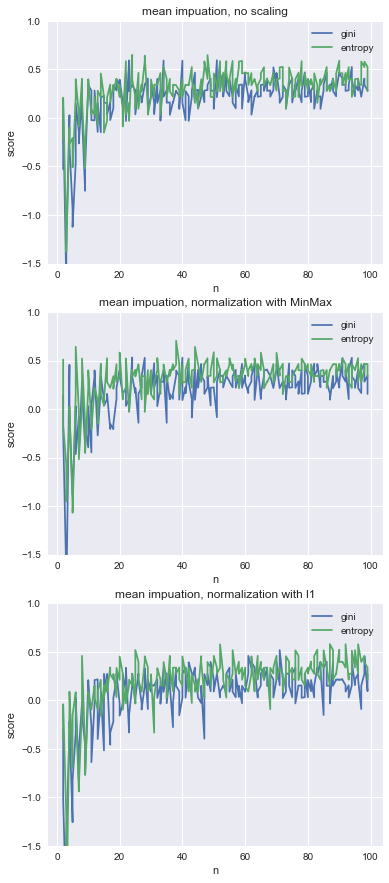

Finished evaluation
Best parameteters found with: {'n_estimators': 81, 'criterion': 'entropy', 'max_features': 'sqrt'}
score= (0.5254237288135594, 0.5254237288135594)
Total evaluation time = 169.35s
Finished evaluation
Best parameteters found with: {'n_estimators': 86, 'criterion': 'entropy', 'max_features': 'log2'}
score= (0.5847457627118644, 0.5847457627118644)
Total evaluation time = 154.04s
Finished evaluation
Best parameteters found with: {'n_estimators': 37, 'criterion': 'entropy', 'max_features': 'log2'}
score= (0.7100484261501211, 0.7100484261501211)
Total evaluation time = 146.47s


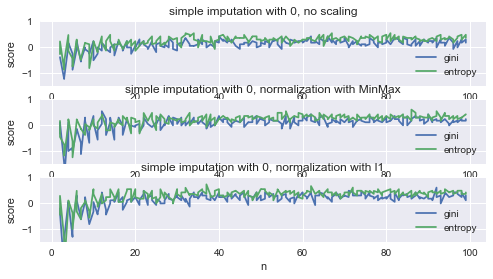

In [5]:
plt.subplots_adjust(top=4)
plt.style.use('seaborn')
#plt.figure(figsize=(8, 4))

plt.subplots_adjust(top=4)
plt.style.use('seaborn')
generatePlots(raw_data, 
    SimpleImputer(missing_values=np.NaN, strategy="mean"), 
    imputation_suffix="simpleImputationMean", title="mean impuation")

generatePlots(raw_data, 
    SimpleImputer(missing_values=np.NaN, strategy="constant", fill_value=0), 
    imputation_suffix="simpleImputation0", title="simple imputation with 0")





In [7]:
# L1 Norm
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="mean").fit_transform(raw_data))
preprocessed_data = pd.DataFrame(Normalizer(norm="l1").fit_transform(preprocessed_data))    # Normalization with l1


#n_estimators': 38, 'criterion': 'entropy', 'max_features': 'sqrt'}
x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, labels, test_size=0.3, random_state=1)
for n in range(10,40):
    model = RFC(n_estimators=n, criterion="entropy", max_features="sqrt", random_state=1)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mat = confusion_matrix(y_test, y_pred)
    if companies_data_preprocessor.calculate_score(y_test, y_pred) > 0.3:
        print("Accuracy=", accuracy_score(y_test, y_pred))
        print("Score=", companies_data_preprocessor.calculate_score(y_test, y_pred))
        print("F1=", f1_score(y_test, y_pred))

        print("precisions=", precision_score(y_test, y_pred))
        print("Recall=", recall_score(y_test, y_pred))

        print(mat)